In [1]:
import pandas as pd

df = pd.read_parquet('data/preprocessed.parquet')

In [2]:
df.shape

(8670130, 27)

In [3]:
df.head()

,Avg Packet Size,Packet Length Mean,Bwd Packet Length Std,Packet Length Variance,Bwd Packet Length Max,Packet Length Max,Packet Length Std,Avg Fwd Segment Size,Fwd Packet Length Mean,Flow Bytes/s,...,Fwd Act Data Packets,Subflow Fwd Packets,Total Fwd Packets,Bwd Header Length,Flow IAT Mean,Flow IAT Min,Fwd IAT Min,Fwd IAT Mean,Idle Std,ClassLabel
0,9.00000,6.000000,0.000000,0.000000,0.0,6.0,0.000000,6.00000,6.00000,3.000000e+06,...,1,2,2,0,4.000000,4.0,4.0,4.0,0.0,0
1,9.00000,6.000000,0.000000,0.000000,0.0,6.0,0.000000,6.00000,6.00000,1.200000e+07,...,1,2,2,0,1.000000,1.0,1.0,1.0,0.0,0
2,9.00000,6.000000,0.000000,0.000000,0.0,6.0,0.000000,6.00000,6.00000,4.000000e+06,...,1,2,2,0,3.000000,3.0,3.0,3.0,0.0,0
3,9.00000,6.000000,0.000000,0.000000,0.0,6.0,0.000000,6.00000,6.00000,1.200000e+07,...,1,2,2,0,1.000000,1.0,1.0,1.0,0.0,0
4,81.63636,74.833336,119.511505,11562.151367,207.0,233.0,107.527443,69.14286,69.14286,1.474548e+06,...,5,7,7,104,60.900002,2.0,2.0,101.5,0.0,0


In [4]:
df.dtypes

Avg Packet Size             float32
Packet Length Mean          float32
Bwd Packet Length Std       float32
Packet Length Variance      float32
Bwd Packet Length Max       float64
Packet Length Max           float64
Packet Length Std           float32
Avg Fwd Segment Size        float32
Fwd Packet Length Mean      float32
Flow Bytes/s                float64
Avg Bwd Segment Size        float32
Bwd Packet Length Mean      float32
Fwd Packets/s               float32
Flow Packets/s              float64
Init Fwd Win Bytes            int32
Subflow Fwd Bytes             int32
Fwd Packets Length Total    float64
Fwd Act Data Packets          int32
Subflow Fwd Packets           int32
Total Fwd Packets             int32
Bwd Header Length             int64
Flow IAT Mean               float32
Flow IAT Min                float64
Fwd IAT Min                 float64
Fwd IAT Mean                float32
Idle Std                    float32
ClassLabel                    int64
dtype: object

In [5]:
min_count = df['ClassLabel'].value_counts().min()
df['ClassLabel'].value_counts(), min_count

(ClassLabel
 0    7186189
 3    1234729
 1     145968
 2     103244
 Name: count, dtype: int64,
 np.int64(103244))

In [6]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['ClassLabel'], axis=1)
y = df['ClassLabel']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6069091, 26), (2601039, 26), (6069091,), (2601039,))

In [7]:
type(X_train), type(X_test), type(y_train), type(y_test)

(pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.series.Series,
 pandas.core.series.Series)

In [8]:
numerical_cols = X.select_dtypes(include='number').columns.tolist()
numerical_cols

['Avg Packet Size',
 'Packet Length Mean',
 'Bwd Packet Length Std',
 'Packet Length Variance',
 'Bwd Packet Length Max',
 'Packet Length Max',
 'Packet Length Std',
 'Avg Fwd Segment Size',
 'Fwd Packet Length Mean',
 'Flow Bytes/s',
 'Avg Bwd Segment Size',
 'Bwd Packet Length Mean',
 'Fwd Packets/s',
 'Flow Packets/s',
 'Init Fwd Win Bytes',
 'Subflow Fwd Bytes',
 'Fwd Packets Length Total',
 'Fwd Act Data Packets',
 'Subflow Fwd Packets',
 'Total Fwd Packets',
 'Bwd Header Length',
 'Flow IAT Mean',
 'Flow IAT Min',
 'Fwd IAT Min',
 'Fwd IAT Mean',
 'Idle Std']

In [9]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline as SciPipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import os

allocated_cpus = os.cpu_count() // 2

scaling_transformer = SciPipeline(
    steps=[("scaler", MinMaxScaler(feature_range=(0, 1)))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("scaling_transformer", scaling_transformer, numerical_cols),
    ],
    remainder="passthrough",  # ensures other columns, if any, are not dropped
)

pipeline = ImbPipeline(
    [
        ("preprocessor", preprocessor),
        ("under", RandomUnderSampler(random_state=69, sampling_strategy="majority")),
        ("classifier", GaussianNB()),
    ]
)

# Define parameter grid for GridSearchCV
param_grid = [
    {
        "classifier": [
            LGBMClassifier(
                n_jobs=allocated_cpus,
            )
        ],
        "classifier__num_leaves": [25, 50],
        "classifier__n_estimators": [25, 50],
        "classifier__learning_rate": [0.1, 0.01],
    },
    {
        "classifier": [XGBClassifier(n_jobs=allocated_cpus)],
        "classifier__max_depth": [3, 6],
        "classifier__n_estimators": [25, 50],
        "classifier__learning_rate": [0.1, 0.01],
    },
    {"classifier": [GaussianNB()]},
]

In [10]:
from collections import Counter

class_counts = Counter(y_train)

print(class_counts)

Counter({0: 5029865, 3: 864704, 1: 102210, 2: 72312})


In [11]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
kf = StratifiedKFold(n_splits=3, random_state=69, shuffle=True)

grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring='f1_macro', n_jobs=os.cpu_count()//2, verbose=3)
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
grid_search.best_estimator_

Fitting 3 folds for each of 17 candidates, totalling 51 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6339
[LightGBM] [Info] Number of data points in the train set: 1111538, number of used features: 26
[LightGBM] [Info] Start training from score -2.732510
[LightGBM] [Info] Start training from score -2.386470
[LightGBM] [Info] Start training from score -2.732510
[LightGBM] [Info] Start training from score -0.251113
Best parameters found:  {'classifier': LGBMClassifier(n_jobs=6), 'classifier__learning_rate': 0.1, 'classifier__n_estimators': 50, 'classifier__num_leaves': 50}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaling_transformer',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Avg Packet Size',
                                                   'Packet Length Mean',
                                                   'Bwd Packet Length Std',
                                                   'Packet Length Variance',
                                                   'Bwd Packet Length Max',
                                                   'Packet Length Max',
                                                   'Packet Length Std',
                                                   'Avg Fwd Segment Size',
                                                   'Fwd Packet Length Mean',
                                                   'Flow Bytes/s',
                                                   'A...
                                                   'Flow Packets/s',
                                                   'Init Fwd Win Bytes',
                                                   'Subflow Fwd Bytes',
                                                   'Fwd Packets Length Total',
                                                   'Fwd Act Data Packets',
                                                   'Subflow Fwd Packets',
                                                   'Total Fwd Packets',
                                                   'Bwd Header Length',
                                                   'Flow IAT Mean',
                                                   'Flow IAT Min',
                                                   'Fwd IAT Min',
                                                   'Fwd IAT Mean',
                                                   'Idle Std'])])),
                ('under',
                 RandomUnderSampler(random_state=69,
                                    sampling_strategy='majority')),
                ('classifier',
                 LGBMClassifier(n_estimators=50, n_jobs=6, num_leaves=50))])

In [12]:
import json
from sklearn.metrics import classification_report

y_pred = grid_search.best_estimator_.predict(X_test)
print(json.dumps(classification_report(y_test, y_pred, output_dict=True), indent=4))

{
    "0": {
        "precision": 0.9999501497371447,
        "recall": 0.9953610867383565,
        "f1-score": 0.9976503409910681,
        "support": 2156324.0
    },
    "1": {
        "precision": 0.966308766348533,
        "recall": 0.9995657936834408,
        "f1-score": 0.9826559726809103,
        "support": 43758.0
    },
    "2": {
        "precision": 0.9916947250280583,
        "recall": 0.9998060261218156,
        "f1-score": 0.9957338570761627,
        "support": 30932.0
    },
    "3": {
        "precision": 0.9782553508813683,
        "recall": 0.9997675832714006,
        "f1-score": 0.9888944876080445,
        "support": 370025.0
    },
    "accuracy": 0.9961115538828906,
    "macro avg": {
        "precision": 0.9840522479987761,
        "recall": 0.9986251224537532,
        "f1-score": 0.9912336645890465,
        "support": 2601039.0
    },
    "weighted avg": {
        "precision": 0.9961997044735293,
        "recall": 0.9961115538828906,
        "f1-score": 0.9961296

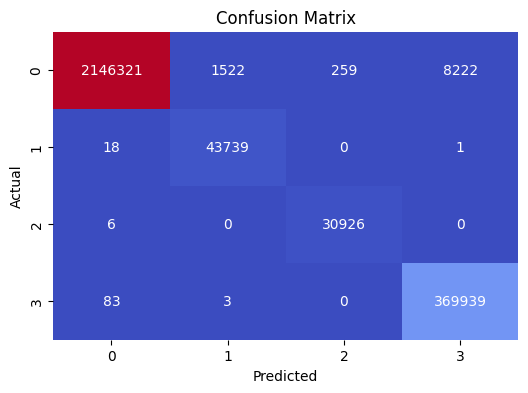

In [13]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', cbar=False)
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

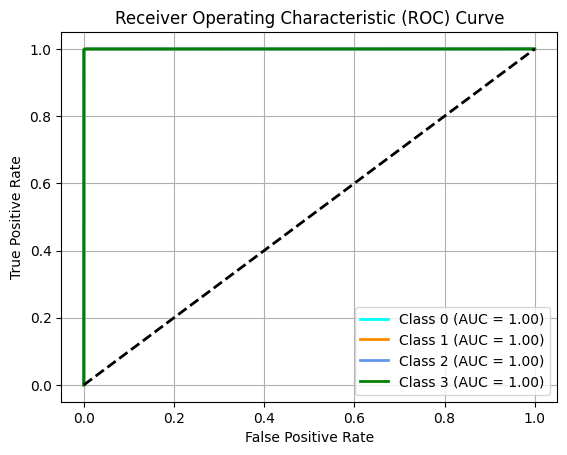

In [14]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import numpy as np


n_classes = len(np.unique(y_test))
y_test_binarized = label_binarize(y_test, classes=np.arange(n_classes))

y_score = grid_search.best_estimator_.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [15]:
import pickle
with open('models/best_model.pkl', 'wb') as f:
    pickle.dump(grid_search.best_estimator_, f)

In [19]:
with open('models/best_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)


In [43]:
data_to_predict = X_test.iloc[991].tolist()

In [41]:
X_train.columns == X_test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [45]:
data_to_predict_df = pd.DataFrame([data_to_predict], columns=X_test.columns)
loaded_model.predict(data_to_predict_df)

array([0])